In [62]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow import keras

In [63]:
import os
results = np.load('/Users/sean/Desktop/college/intern/2D Wall/2D_Wall_Propped.npy')

In [64]:
E = 3e10 #Pa
nu = 0.2 # Poisson's ratio
G = E / (2 * (1 + nu)) # Shear modulus
rho = 2400 # kg/m^3

mesh_size = 0.05

width = 5   # m
depth = 8   # m
t = 0.1     # m
D =  E * t**3 / (12 * (1 - nu**2))

x_prop = width / 2

H_exposed = 5.0
D_embed = 3.0
H_total = H_exposed + D_embed
L = H_total
EI = 20e6  # Nm²
gamma = 18.0 * 1e3  # N/m³
Ka = 0.333
Kp_mobilised = 1.5  # Reduced passive pressure coefficient
Kp = 3.0
z_prop = 2.5       # Depth of prop from top [m]
zR_prop = 60e3   # N/m (resisting direction, into wall)
zR_prop *= width

tol = 1e-7

z_dense_lim1, z_dense_lim2 = 1.5, 3.5
x_dense_lim1, x_dense_lim2 = 1.5, 3.5

def is_in_dense_region(z, x):
    return (z_dense_lim1 <= z) & (z <= z_dense_lim2) & (x_dense_lim1 <= x) & (x <= x_dense_lim2)

In [65]:
x_raw, z_raw, y_raw = np.split(results, 3, axis = -1)
x_raw_flatten, z_raw_flatten, y_raw_flatten = x_raw.flatten(), z_raw.flatten(), y_raw.flatten()

zdim_raw, xdim_raw = x_raw.shape[:2]
zdim = 40
xdim = int(zdim / depth * width)
z_sample_index = np.linspace(0, zdim_raw-1, zdim, dtype=int)
x_sample_index = np.linspace(0, xdim_raw-1, xdim, dtype=int)

z_sampled_raw = np.zeros_like(z_raw)
x_sampled_raw = np.zeros_like(x_raw)
y_sampled_raw = np.zeros_like(y_raw)

for z_in in range(x_raw.shape[0]):
    for x_in in range(x_raw.shape[1]):
        z, x, y = z_raw[z_in, x_in], x_raw[z_in, x_in], y_raw[z_in, x_in]
        if is_in_dense_region(z, x) or (not is_in_dense_region(z,x) and (z_in in z_sample_index) and (x_in in x_sample_index)):
            z_sampled_raw[z_in, x_in] = z
            x_sampled_raw[z_in, x_in] = x
            y_sampled_raw[z_in, x_in] = y
        else:
            z_sampled_raw[z_in, x_in] = np.nan
            x_sampled_raw[z_in, x_in] = np.nan
            y_sampled_raw[z_in, x_in] = np.nan

z_sampled_flatten = z_sampled_raw.flatten()
x_sampled_flatten = x_sampled_raw.flatten()
y_sampled_flatten = y_sampled_raw.flatten()

z_sampled_flatten = z_sampled_flatten[z_sampled_flatten != np.nan]
x_sampled_flatten = x_sampled_flatten[x_sampled_flatten != np.nan]
y_sampled_flatten = y_sampled_flatten[y_sampled_flatten != np.nan]

deltaz = z_sampled_raw[1, 0] - z_sampled_raw[0, 0] #for unifrom only
deltax = x_sampled_raw[0, 1] - x_sampled_raw[0, 0]

z_max = np.max(z_raw[:,0])
x_max = np.max(x_raw[0])
y_max = np.max(abs(y_raw))





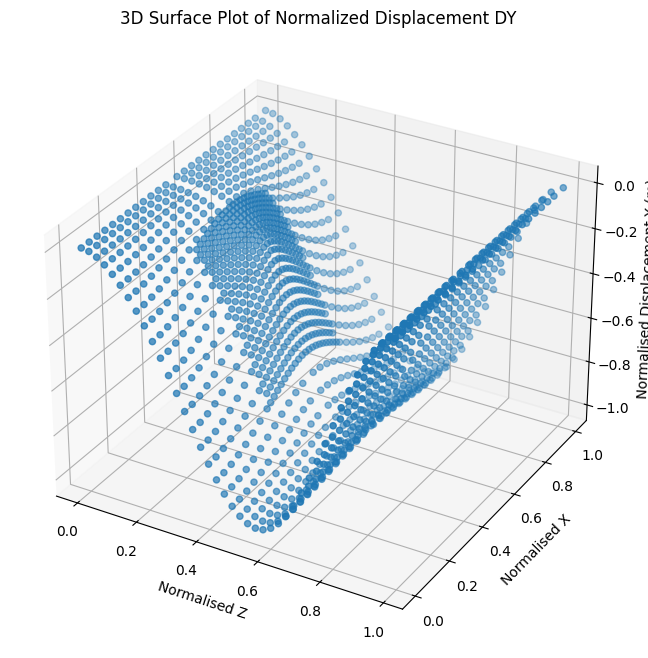

In [66]:
z_norm = z_sampled_raw / depth
x_norm = x_sampled_raw / width
y_norm = y_sampled_raw / y_max

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

z_norm = np.squeeze(z_norm, -1)
x_norm = np.squeeze(x_norm, -1)
y_norm = np.squeeze(y_norm, -1)

z_norm_flatten = z_norm.flatten()
x_norm_flatten = x_norm.flatten()
y_norm_flatten = y_norm.flatten()

results_norm_flatten = np.stack((z_norm_flatten, x_norm_flatten, y_norm_flatten), axis = -1)
# Create a scatter plot
surf = ax.scatter(z_norm_flatten, x_norm_flatten, y_norm_flatten)
# Add labels and title
ax.set_xlabel('Normalised Z')
ax.set_ylabel('Normalised X')
ax.set_zlabel('Normalised Displacement Y (m)')
ax.set_title('3D Surface Plot of Normalized Displacement DY')

plt.show()

In [67]:
def q_soil_smooth(z, width=0.2):

    # Lines on either side of the break
    m1      =  Ka * gamma                                   # slope for z ≤ H
    m2      = (Ka - Kp_mobilised) * gamma                   # slope for z ≥ H
    c2      =  Kp_mobilised * gamma * H_exposed             # intercept so the
                                                            # two branches meet
    # Smooth switch 0→1 built from tanh
    w = 0.5 * (1 + np.tanh((z - H_exposed) / width))        # 0 left, 1 right

    return (1 - w) * (m1 * z) + w * (m2 * z + c2)
def gaussian_prop(z, x, delta_z, delta_x, force, xc = width/2, zc = z_prop, sigma = 1e-2):

    phi = force * tf.exp(-((x - xc)**2 + (z - zc)**2) / (2 * sigma**2))
    scale = 1 / (sigma * np.sqrt(2 * np.pi))
    
    return scale * phi
q_s = q_soil_smooth(z_flatten)
q_max = max(q_s)
q_norm = q_s / q_max


In [68]:
model = keras.Sequential([
    keras.layers.Input(shape = (2,)),
    keras.layers.Dense(64, activation='swish'),
    keras.layers.Dense(64, activation='swish'),
    keras.layers.Dense(64, activation='swish'),
    keras.layers.Dense(64, activation='swish'),
    keras.layers.Dense(1)
])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,737 (49.75 KB)

 Trainable params: 12,737 (49.75 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# --- 8. Initialize b1, c1, b2, c2
m_a = tf.Variable(0.5, dtype=tf.float32)
m_p = tf.Variable(1, dtype=tf.float32)
m_prop = tf.Variable(1, dtype=tf.float32)


# --- 9. Learning Rate Scheduler ---
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005, # Slightly lower initial LR
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


physics loss

In [70]:

def laplacian(inputs, func = model):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(inputs)
        with tf.GradientTape() as tape1:
            tape1.watch(inputs)
            f = func(inputs)
        grad = tape1.gradient(f, inputs)  # shape (N, D)
        dz, dx = tf.unstack(grad, axis = -1)
    
    
    dz2 = tf.unstack(tape2.gradient(dz, inputs), axis = -1)[0]
    dx2 = tf.unstack(tape2.gradient(dx, inputs), axis = -1)[1]
    
    return dz2 / z_max**2 + dx2 / x_max**2

def first_order_grad(inputs):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        f = model(inputs)
    dz, dx = tf.unstack(tape.gradient(f, inputs), axis = -1)
    dz = dz / z_max
    dx = dx / x_max
    g = tf.stack((dz, dx), axis = -1)
    return g

In [71]:
def gaussian_2D(z, x, dz, dx, force, xc = width/2, zc = z_prop, sigma = 1e-2):

  force, xc, zc, sigma = tf.cast(force, tf.float32), tf.cast(xc, tf.float32), tf.cast(zc, tf.float32), tf.cast(sigma, tf.float32)
  
  r2 = ((x - xc)**2 + (z - zc)**2) / (2 * sigma**2)
  phi = tf.exp(-r2)
  scale = force / (tf.reduce_sum(phi) * dx * dz)

  return scale * phi

def piecewise_q(z_norm_flatten_tf, x_norm_flatten_tf):  #input normalized
    z_phys = z_norm_flatten_tf * z_max
    q_s = tf.where(z_phys <= H_exposed, (m_a * gamma * Ka * z_phys), (m_a * gamma * Ka * z_phys - m_p*gamma*Kp*(z_phys-H_exposed)))
    
    deltaz, deltax = tf.cast(deltaz, tf.float32), tf.cast(deltax, tf.float32)
    q_prop = gaussian_2D(z_phys, x_norm_flatten_tf * x_max, deltaz, deltax, zR_prop)
    return q_s - q_prop
q_test = piecewise_q(z_norm_flatten, x_norm_flatten)
fig.add_axes(ax)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_norm_flatten, x_norm_flatten, q_test)

UnboundLocalError: cannot access local variable 'deltaz' where it is not associated with a value

In [ ]:
N_DATA_ONLY_EPOCHS = 2000
N_BC_EPOCHS = 1000
N_PHYSICS_EPOCHS = 2000

@tf.function

def train_step(batch, epoch_val):
  z, x , y_true = batch[:,0], batch[:,1], batch[:,2]
  
  with tf.GradientTape() as tape:
    zxstack = tf.stack((z, x), axis = -1)
    y_pred = model(zxstack)
    y_pred = tf.squeeze(y_pred, -1)  # Ensure y_pred is 1D
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    y_at_z_boundaries = tf.where(z < (1 / zdim), y_pred, 0.0) + tf.where((1 - z) < (1 / zdim), y_pred, 0.0)
    bc_disp = tf.reduce_mean(tf.square(y_at_z_boundaries))
    
    gradz, gradx = tf.unstack(first_order_grad(zxstack), axis = -1)
    gradz_at_z_boundaries = tf.where(z < (1 / zdim), gradz, 0.0) + tf.where((1 - z) < (1 / zdim), gradz, 0.0)
    bc_z_loss = tf.reduce_mean(tf.square(gradz_at_z_boundaries))
    
    gradx_at_x_boundaries = tf.where(x < (1 / xdim), gradx, 0.0) + tf.where((1 - x) < (1 / xdim), gradx, 0.0)
    bc_x_loss = tf.reduce_sum(tf.square(gradx_at_x_boundaries)) 
    
    bc_loss = bc_disp + bc_z_loss + bc_x_loss
      
    biharmonic = laplacian(zxstack, laplacian)
    q_pred = piecewise_q(z, x)
    physics_residual = tf.square(biharmonic * D * y_max / q_max - q_pred / q_max)
    physics_loss = tf.reduce_mean(physics_residual)

    if epoch_val < N_DATA_ONLY_EPOCHS:
        w_data, w_phys, w_bc = 1.0, 0.0, 0.2
    elif epoch_val < N_BC_EPOCHS:
        w_data, w_phys, w_bc = 0.2, 0.5, 0.1
    else:
        w_data, w_phys, w_bc = 1.0, 0.1, 0.2
        
    loss = w_data * data_loss + w_bc * bc_loss + w_phys * physics_loss

  variables = model.trainable_variables + [m_a, m_p]
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  del tape
  return loss, data_loss, bc_loss, physics_loss



In [ ]:
def snapshot(model):
    snap = keras.models.clone_model(model)
    snap.build(model.input_shape)
    snap.set_weights(model.get_weights())
    return snap

In [ ]:
# --- 0. batching parameters --------------------------------------------
BATCH_SIZE  = 1024
SHUFFLE_BUF = 10_000

model_phase1, model_phase2 = model, model

dataset = (tf.data.Dataset.from_tensor_slices(
              tf.convert_to_tensor(results_norm_flatten, dtype=tf.float32))
           .shuffle(SHUFFLE_BUF, reshuffle_each_iteration=True)
           .batch(BATCH_SIZE)
           .prefetch(tf.data.AUTOTUNE))

# --- 1. history containers ---------------------------------------------
history        = {k: [] for k in ["loss", "data", "phys", "bc"]}
history_params = {"m_a": [], "m_p": []}

In [ ]:
# --- 2. training loop ---------------------------------------------------
for epoch in range(5000):
    # We’ll keep the metrics from the *last* batch in this epoch
    for batch in dataset:
        loss, data_l, bc_l, phys_l = train_step(batch, tf.cast(epoch, tf.int32))

    # record those metrics (no division → no ZeroDivisionError)
    history["loss"].append(float(loss.numpy()))
    history["data"].append(float(data_l.numpy()))
    history["phys"].append(float(phys_l.numpy()))
    history["bc"].append(float(bc_l.numpy()))
    history_params["m_a"].append(m_a.numpy())
    history_params["m_p"].append(m_p.numpy())

    if epoch % 5 == 0:
        print(f"Epoch {epoch:3d} | "
              f"loss {loss.numpy():.3e} | "
              f"data {data_l.numpy():.3e} | "
              f"bc {bc_l.numpy():.3e} | "
              f"phys {phys_l.numpy():.3e}")
    
    if epoch == N_DATA_ONLY_EPOCHS - 1:
        model_phase1 = snapshot(model)
    if epoch == N_DATA_ONLY_EPOCHS + N_BC_EPOCHS - 1:
        model_phase2 = snapshot(model)


2025-08-08 16:02:41.713813: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-08 16:02:41.781598: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-08 16:02:41.892715: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch   0 | loss 3.184e-01 | data 3.183e-01 | bc 3.632e-04 | phys 6.451e+01
Epoch   5 | loss 2.754e-01 | data 2.753e-01 | bc 7.816e-04 | phys 6.451e+01


2025-08-08 16:02:42.209925: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch  10 | loss 2.363e-01 | data 2.352e-01 | bc 5.516e-03 | phys 6.451e+01


2025-08-08 16:02:42.666622: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch  15 | loss 1.994e-01 | data 1.963e-01 | bc 1.585e-02 | phys 6.451e+01
Epoch  20 | loss 1.660e-01 | data 1.593e-01 | bc 3.350e-02 | phys 6.451e+01
Epoch  25 | loss 1.411e-01 | data 1.295e-01 | bc 5.783e-02 | phys 6.451e+01
Epoch  30 | loss 1.291e-01 | data 1.139e-01 | bc 7.574e-02 | phys 6.451e+01


2025-08-08 16:02:43.530232: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch  35 | loss 1.239e-01 | data 1.107e-01 | bc 6.613e-02 | phys 6.451e+01
Epoch  40 | loss 1.177e-01 | data 1.100e-01 | bc 3.822e-02 | phys 6.451e+01
Epoch  45 | loss 1.130e-01 | data 1.094e-01 | bc 1.755e-02 | phys 6.451e+01
Epoch  50 | loss 1.118e-01 | data 1.097e-01 | bc 1.093e-02 | phys 6.451e+01
Epoch  55 | loss 1.120e-01 | data 1.098e-01 | bc 1.146e-02 | phys 6.451e+01
Epoch  60 | loss 1.119e-01 | data 1.094e-01 | bc 1.254e-02 | phys 6.451e+01


2025-08-08 16:02:45.310675: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch  65 | loss 1.115e-01 | data 1.090e-01 | bc 1.253e-02 | phys 6.451e+01
Epoch  70 | loss 1.113e-01 | data 1.089e-01 | bc 1.211e-02 | phys 6.451e+01
Epoch  75 | loss 1.110e-01 | data 1.087e-01 | bc 1.168e-02 | phys 6.451e+01
Epoch  80 | loss 1.108e-01 | data 1.085e-01 | bc 1.130e-02 | phys 6.451e+01
Epoch  85 | loss 1.107e-01 | data 1.085e-01 | bc 1.109e-02 | phys 6.451e+01
Epoch  90 | loss 1.106e-01 | data 1.084e-01 | bc 1.108e-02 | phys 6.451e+01
Epoch  95 | loss 1.105e-01 | data 1.082e-01 | bc 1.117e-02 | phys 6.451e+01
Epoch 100 | loss 1.104e-01 | data 1.081e-01 | bc 1.124e-02 | phys 6.451e+01
Epoch 105 | loss 1.102e-01 | data 1.080e-01 | bc 1.121e-02 | phys 6.451e+01
Epoch 110 | loss 1.101e-01 | data 1.079e-01 | bc 1.114e-02 | phys 6.451e+01
Epoch 115 | loss 1.100e-01 | data 1.078e-01 | bc 1.108e-02 | phys 6.451e+01
Epoch 120 | loss 1.099e-01 | data 1.077e-01 | bc 1.107e-02 | phys 6.451e+01
Epoch 125 | loss 1.098e-01 | data 1.076e-01 | bc 1.107e-02 | phys 6.451e+01


2025-08-08 16:02:53.044897: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 130 | loss 1.097e-01 | data 1.075e-01 | bc 1.108e-02 | phys 6.451e+01
Epoch 135 | loss 1.096e-01 | data 1.074e-01 | bc 1.106e-02 | phys 6.451e+01
Epoch 140 | loss 1.095e-01 | data 1.073e-01 | bc 1.103e-02 | phys 6.451e+01
Epoch 145 | loss 1.094e-01 | data 1.072e-01 | bc 1.101e-02 | phys 6.451e+01
Epoch 150 | loss 1.093e-01 | data 1.071e-01 | bc 1.100e-02 | phys 6.451e+01
Epoch 155 | loss 1.092e-01 | data 1.070e-01 | bc 1.099e-02 | phys 6.451e+01
Epoch 160 | loss 1.091e-01 | data 1.069e-01 | bc 1.099e-02 | phys 6.451e+01
Epoch 165 | loss 1.090e-01 | data 1.068e-01 | bc 1.098e-02 | phys 6.451e+01
Epoch 170 | loss 1.089e-01 | data 1.067e-01 | bc 1.097e-02 | phys 6.451e+01
Epoch 175 | loss 1.087e-01 | data 1.065e-01 | bc 1.096e-02 | phys 6.451e+01
Epoch 180 | loss 1.086e-01 | data 1.064e-01 | bc 1.095e-02 | phys 6.451e+01
Epoch 185 | loss 1.084e-01 | data 1.063e-01 | bc 1.094e-02 | phys 6.451e+01
Epoch 190 | loss 1.083e-01 | data 1.061e-01 | bc 1.092e-02 | phys 6.451e+01
Epoch 195 | 

2025-08-08 16:03:21.325608: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 255 | loss 1.047e-01 | data 1.026e-01 | bc 1.059e-02 | phys 6.451e+01
Epoch 260 | loss 1.041e-01 | data 1.020e-01 | bc 1.054e-02 | phys 6.451e+01
Epoch 265 | loss 1.035e-01 | data 1.014e-01 | bc 1.047e-02 | phys 6.451e+01
Epoch 270 | loss 1.027e-01 | data 1.006e-01 | bc 1.040e-02 | phys 6.451e+01
Epoch 275 | loss 1.018e-01 | data 9.972e-02 | bc 1.031e-02 | phys 6.451e+01
Epoch 280 | loss 1.007e-01 | data 9.865e-02 | bc 1.022e-02 | phys 6.451e+01
Epoch 285 | loss 9.937e-02 | data 9.735e-02 | bc 1.011e-02 | phys 6.451e+01
Epoch 290 | loss 9.774e-02 | data 9.574e-02 | bc 9.996e-03 | phys 6.451e+01
Epoch 295 | loss 9.570e-02 | data 9.373e-02 | bc 9.880e-03 | phys 6.451e+01
Epoch 300 | loss 9.314e-02 | data 9.119e-02 | bc 9.774e-03 | phys 6.451e+01
Epoch 305 | loss 8.988e-02 | data 8.794e-02 | bc 9.701e-03 | phys 6.451e+01
Epoch 310 | loss 8.569e-02 | data 8.376e-02 | bc 9.690e-03 | phys 6.451e+01
Epoch 315 | loss 8.032e-02 | data 7.836e-02 | bc 9.763e-03 | phys 6.451e+01
Epoch 320 | 

2025-08-08 16:04:18.445372: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 515 | loss 1.577e-02 | data 1.312e-02 | bc 1.325e-02 | phys 6.445e+01
Epoch 520 | loss 1.564e-02 | data 1.299e-02 | bc 1.324e-02 | phys 6.445e+01
Epoch 525 | loss 1.550e-02 | data 1.285e-02 | bc 1.326e-02 | phys 6.445e+01
Epoch 530 | loss 1.537e-02 | data 1.273e-02 | bc 1.321e-02 | phys 6.446e+01
Epoch 535 | loss 1.524e-02 | data 1.261e-02 | bc 1.315e-02 | phys 6.446e+01
Epoch 540 | loss 1.510e-02 | data 1.248e-02 | bc 1.308e-02 | phys 6.446e+01
Epoch 545 | loss 1.495e-02 | data 1.235e-02 | bc 1.300e-02 | phys 6.446e+01
Epoch 550 | loss 1.481e-02 | data 1.222e-02 | bc 1.292e-02 | phys 6.446e+01
Epoch 555 | loss 1.465e-02 | data 1.208e-02 | bc 1.284e-02 | phys 6.447e+01
Epoch 560 | loss 1.449e-02 | data 1.195e-02 | bc 1.272e-02 | phys 6.447e+01
Epoch 565 | loss 1.433e-02 | data 1.181e-02 | bc 1.258e-02 | phys 6.448e+01
Epoch 570 | loss 1.417e-02 | data 1.166e-02 | bc 1.258e-02 | phys 6.448e+01
Epoch 575 | loss 1.456e-02 | data 1.221e-02 | bc 1.171e-02 | phys 6.449e+01
Epoch 580 | 

2025-08-08 16:06:12.747056: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1025 | loss 3.242e-03 | data 2.881e-03 | bc 1.805e-03 | phys 6.626e+01
Epoch 1030 | loss 3.231e-03 | data 2.874e-03 | bc 1.785e-03 | phys 6.627e+01
Epoch 1035 | loss 3.221e-03 | data 2.868e-03 | bc 1.763e-03 | phys 6.628e+01
Epoch 1040 | loss 3.211e-03 | data 2.863e-03 | bc 1.738e-03 | phys 6.629e+01
Epoch 1045 | loss 3.201e-03 | data 2.859e-03 | bc 1.711e-03 | phys 6.630e+01
Epoch 1050 | loss 3.192e-03 | data 2.855e-03 | bc 1.683e-03 | phys 6.630e+01
Epoch 1055 | loss 3.183e-03 | data 2.851e-03 | bc 1.657e-03 | phys 6.631e+01
Epoch 1060 | loss 3.174e-03 | data 2.847e-03 | bc 1.634e-03 | phys 6.632e+01
Epoch 1065 | loss 3.165e-03 | data 2.842e-03 | bc 1.613e-03 | phys 6.633e+01
Epoch 1070 | loss 3.156e-03 | data 2.838e-03 | bc 1.591e-03 | phys 6.634e+01
Epoch 1075 | loss 3.148e-03 | data 2.835e-03 | bc 1.568e-03 | phys 6.634e+01
Epoch 1080 | loss 3.140e-03 | data 2.831e-03 | bc 1.545e-03 | phys 6.635e+01
Epoch 1085 | loss 3.132e-03 | data 2.828e-03 | bc 1.524e-03 | phys 6.636e+01

2025-08-08 16:10:01.235107: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2050 | loss 6.349e+00 | data 2.339e-02 | bc 4.318e-02 | phys 6.317e+01
Epoch 2055 | loss 6.341e+00 | data 2.666e-02 | bc 5.005e-02 | phys 6.305e+01
Epoch 2060 | loss 6.334e+00 | data 2.880e-02 | bc 5.228e-02 | phys 6.294e+01
Epoch 2065 | loss 6.328e+00 | data 3.064e-02 | bc 5.370e-02 | phys 6.286e+01
Epoch 2070 | loss 6.323e+00 | data 3.286e-02 | bc 5.616e-02 | phys 6.279e+01
Epoch 2075 | loss 6.320e+00 | data 3.464e-02 | bc 5.789e-02 | phys 6.274e+01
Epoch 2080 | loss 6.318e+00 | data 3.502e-02 | bc 5.731e-02 | phys 6.272e+01
Epoch 2085 | loss 6.316e+00 | data 3.433e-02 | bc 5.480e-02 | phys 6.271e+01
Epoch 2090 | loss 6.314e+00 | data 3.312e-02 | bc 5.211e-02 | phys 6.270e+01
Epoch 2095 | loss 6.311e+00 | data 3.163e-02 | bc 4.947e-02 | phys 6.270e+01
Epoch 2100 | loss 6.309e+00 | data 3.011e-02 | bc 4.711e-02 | phys 6.270e+01
Epoch 2105 | loss 6.307e+00 | data 2.875e-02 | bc 4.499e-02 | phys 6.270e+01
Epoch 2110 | loss 6.305e+00 | data 2.762e-02 | bc 4.339e-02 | phys 6.269e+01

2025-08-08 16:17:38.192349: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4095 | loss 5.113e+00 | data 7.384e-03 | bc 1.489e-02 | phys 5.102e+01
Epoch 4100 | loss 5.110e+00 | data 7.376e-03 | bc 1.489e-02 | phys 5.100e+01
Epoch 4105 | loss 5.108e+00 | data 7.367e-03 | bc 1.489e-02 | phys 5.098e+01
Epoch 4110 | loss 5.106e+00 | data 7.359e-03 | bc 1.489e-02 | phys 5.095e+01
Epoch 4115 | loss 5.104e+00 | data 7.351e-03 | bc 1.489e-02 | phys 5.093e+01
Epoch 4120 | loss 5.101e+00 | data 7.343e-03 | bc 1.489e-02 | phys 5.091e+01
Epoch 4125 | loss 5.099e+00 | data 7.335e-03 | bc 1.489e-02 | phys 5.089e+01
Epoch 4130 | loss 5.097e+00 | data 7.327e-03 | bc 1.489e-02 | phys 5.086e+01
Epoch 4135 | loss 5.094e+00 | data 7.319e-03 | bc 1.489e-02 | phys 5.084e+01
Epoch 4140 | loss 5.092e+00 | data 7.311e-03 | bc 1.489e-02 | phys 5.081e+01
Epoch 4145 | loss 5.089e+00 | data 7.305e-03 | bc 1.490e-02 | phys 5.079e+01
Epoch 4150 | loss 5.087e+00 | data 7.285e-03 | bc 1.489e-02 | phys 5.077e+01
Epoch 4155 | loss 5.162e+00 | data 7.443e-03 | bc 1.498e-02 | phys 5.151e+01

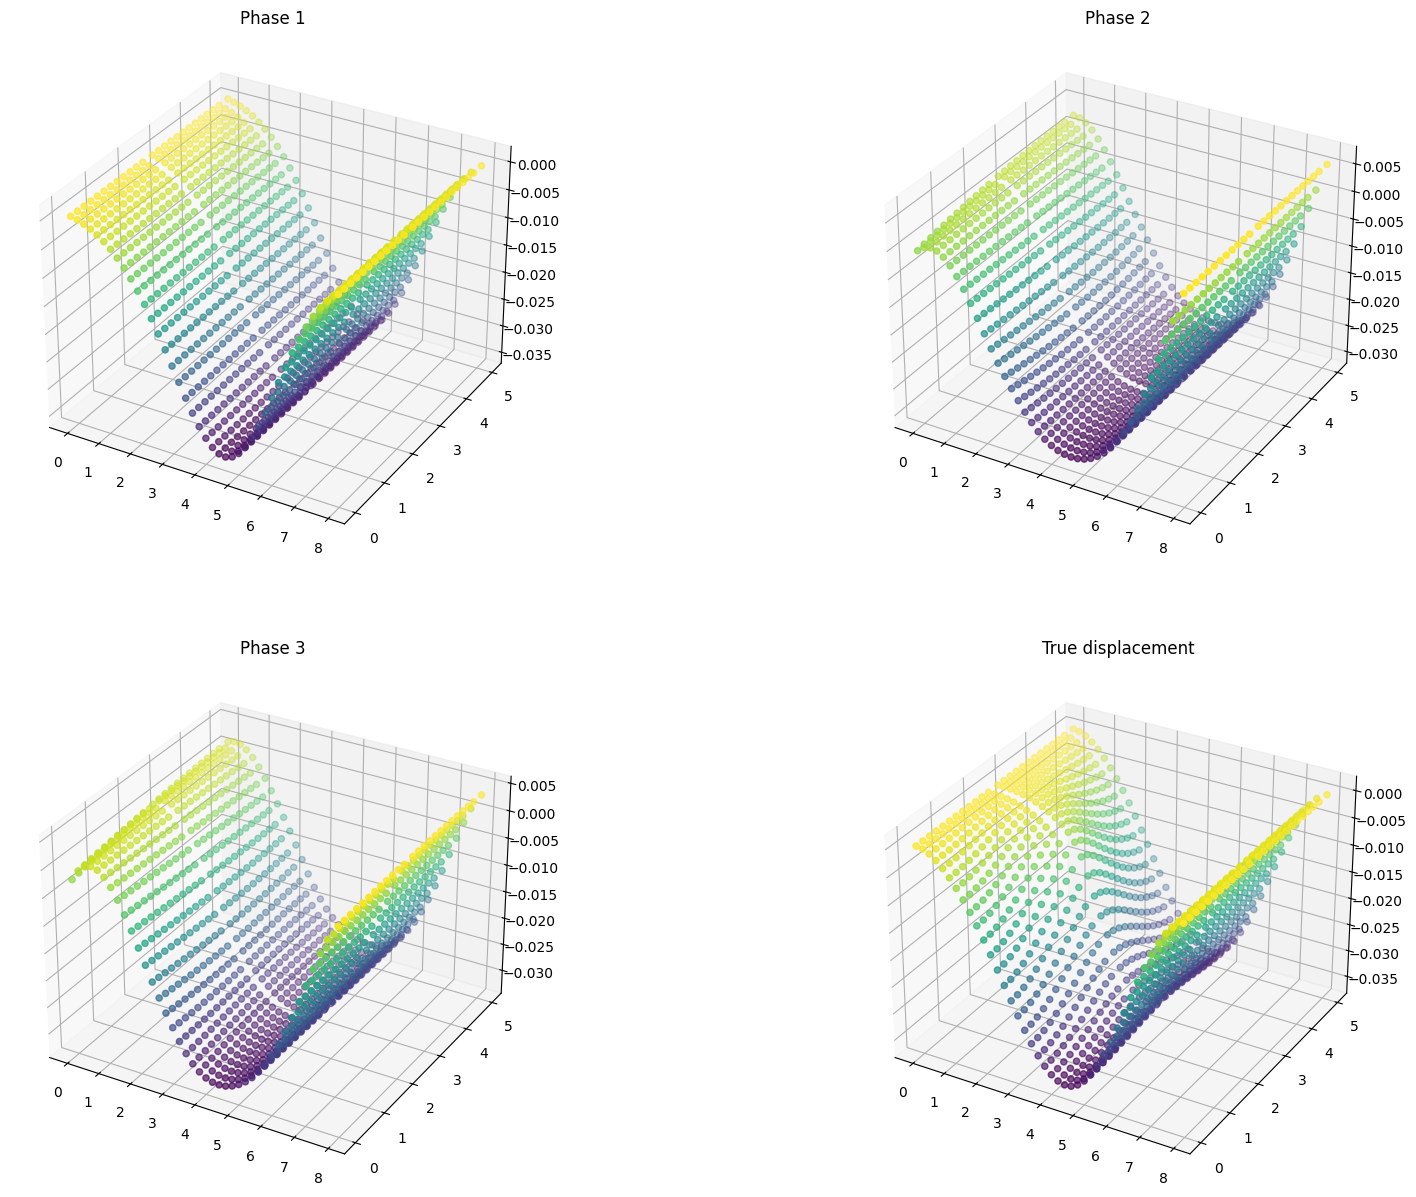

In [ ]:
z_norm_flatten_tf = tf.convert_to_tensor(z_norm_flatten, dtype=tf.float32)
x_norm_flatten_tf = tf.convert_to_tensor(x_norm_flatten, dtype=tf.float32)

zxstack = tf.stack((z_norm_flatten_tf, x_norm_flatten_tf), axis = -1)

y_pred_norm1 = model_phase1(zxstack)
y_pred_norm1 = np.squeeze(y_pred_norm1, -1)
y_pred1 = y_pred_norm1 * y_max

y_pred_norm2 = model_phase2(zxstack)
y_pred_norm2 = np.squeeze(y_pred_norm2, -1)
y_pred2 = y_pred_norm2 * y_max

y_pred_norm3 = model(zxstack)
y_pred_norm3 = np.squeeze(y_pred_norm3, -1)
y_pred3 = y_pred_norm3 * y_max

fig = plt.figure(figsize=(20, 15))

ax1 = fig.add_subplot(221, projection = '3d')
ax1.scatter(z_flatten, x_flatten, y_pred1, c = y_pred1, cmap = 'viridis')
ax1.set_title('Phase 1')

ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(z_flatten, x_flatten, y_pred2, c = y_pred2, cmap='viridis')
ax2.set_title('Phase 2')

ax3 = fig.add_subplot(223, projection = '3d')
ax3.scatter(z_flatten, x_flatten, y_pred3, c = y_pred3, cmap = 'viridis')
ax3.set_title('Phase 3')

ax4 = fig.add_subplot(224, projection = '3d')
ax4.scatter(z_flatten, x_flatten, y_flatten, c = y_flatten, cmap = 'viridis')
ax4.set_title('True displacement')

plt.show()

0.388181657 0.82656908


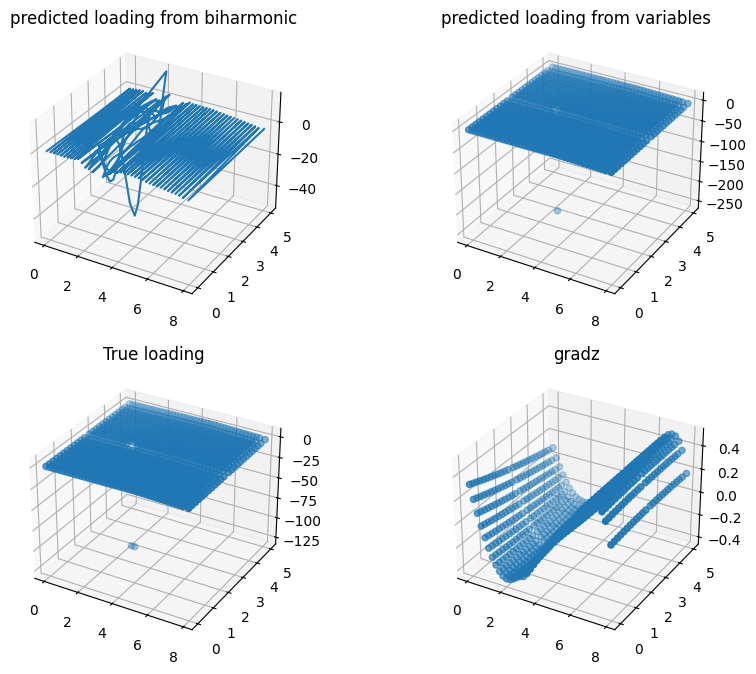

In [ ]:
bih = laplacian(zxstack, laplacian)

cut = 0
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(221, projection = '3d')
ax1.plot(z_flatten[cut*xdim:], x_flatten[cut*xdim:], bih[cut*xdim:]* D * y_max / q_max)
ax1.set_title('predicted loading from biharmonic')

q_params = piecewise_q(z_norm_flatten_tf, x_norm_flatten_tf)
ax2 = fig.add_subplot(222, projection = '3d')
ax2.scatter(z_flatten[cut*xdim:], x_flatten[cut*xdim:], q_params[cut*xdim:]/q_max)
ax2.set_title('predicted loading from variables')

q_true = q_soil_smooth(z_flatten) - gaussian_2D(z_flatten, x_flatten, deltaz, deltax, zR_prop)
ax3 = fig.add_subplot(223, projection = '3d')
ax3.scatter(z_flatten[cut*xdim:], x_flatten[cut*xdim:], q_true[cut*xdim:]/q_max)
ax3.set_title('True loading')

gz, gx = tf.unstack(first_order_grad(zxstack), axis = -1)
ax4 = fig.add_subplot(224, projection = '3d')
ax4.scatter(z_flatten[cut*xdim:], x_flatten[cut*xdim:], gz[cut*xdim:])
ax4.set_title('gradz')
tf.print(m_a, m_p)